In [4]:
from langchain_astradb import AstraDBLoader
import os
from dotenv import load_dotenv
import json
from langchain_openai import ChatOpenAI
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=1,  # <-- Super slow! We can only make a request once every 10 seconds!!
    check_every_n_seconds=0.1,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

cleaned_name = "lecture_slides_-_decision_and_game_theory_i_-_winter_2024.pdf"
collection_name = "game_theory"

ASTRA_TOKEN = os.getenv('ASTRA_TOKEN')
ASTRA_ENDPOINT = os.getenv('ASTRA_ENDPOINT')
ASTRA_NAMESPACE = os.getenv('ASTRA_NAMESPACE')


llm = ChatOpenAI(model="gpt-4o-mini", rate_limiter=rate_limiter)


def astradb_loader(collection_name, cleaned_name_value):
    filter_criteria = {"metadata.cleaned_name": cleaned_name_value}

    loader = AstraDBLoader(
        api_endpoint=ASTRA_ENDPOINT,
        token=ASTRA_TOKEN,
        namespace=ASTRA_NAMESPACE,
        collection_name=collection_name,
        filter_criteria=filter_criteria,
    )
    
    docs = loader.load()
    return docs

In [3]:
# docs = astradb_loader(collection_name, cleaned_name)

In [23]:
from langchain_community.document_loaders import WebBaseLoader
import uuid

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")

docs = loader.load()

for doc in docs:
    doc.id = str(uuid.uuid4())

In [24]:
docs[0]

Document(id='4957e142-99f2-4916-96af-12eb4cd2c6e5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, t

In [7]:
from langchain_community.document_loaders import PyPDFLoader

file_path = (
    "/home/teodorrk/Documents/big data/Theisen_2010_Impact.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

ValueError: File path /home/teodorrk/Documents/big data/Theisen_2010_Impact.pdf is not a valid file or url

In [ ]:
import operator
from typing import Annotated, List, TypedDict, Optional
from pydantic import BaseModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain_core.documents import Document

map_template = "Write a concise summary of the following: {context}."

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

map_prompt = ChatPromptTemplate([("human", map_template)])
reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

map_chain = map_prompt | llm | StrOutputParser()
reduce_chain = reduce_prompt | llm | StrOutputParser()

# Graph components: define the components that will make up the graph

from typing import Literal

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,

)

class OverallState(BaseModel):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(BaseModel):
    content: Optional[str]

# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state.content)
    return {"summaries": [response]}

# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", SummaryState(content=content)) for content in state.contents
    ]

# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state.summaries)
    return {"final_summary": response}


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


token_max = 1000


# Add node to store summaries for collapsing
def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state.summaries]
    }


# Modify final summary to read off collapsed summaries
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state.collapsed_summaries)
    return {"final_summary": response}


graph = StateGraph(OverallState)

graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("generate_final_summary", generate_final_summary)


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state.collapsed_summaries, length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


graph.add_node("collapse_summaries", collapse_summaries)


def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state.collapsed_summaries)
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)
app = graph.compile()

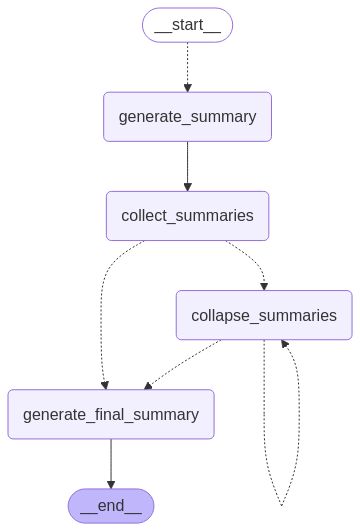

In [10]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
async for step in app.astream(
    {
        "contents": [doc.page_content for doc in docs],
        "summaries": [],  # Initialize with an empty list
        "collapsed_summaries": [],  # Initialize with an empty list
        "final_summary": "",  # Initialize with an empty string
    },
):
    print(list(step.keys()))

['generate_summary']
['collect_summaries']
['generate_final_summary']


In [13]:
print(step)

{'generate_final_summary': {'final_summary': 'The article "LLM Powered Autonomous Agents" by Lilian Weng examines the creation of autonomous agents enhanced by large language models (LLMs). It identifies three core components of an agent system: \n\n1. **Planning**: Utilizing methods like "Chain of Thought" and "Tree of Thoughts," agents break down complex tasks and engage in self-reflection to improve performance.\n2. **Memory**: The framework includes short-term memory for in-context learning and long-term memory for knowledge retention, often enhanced through external vector databases using Maximum Inner Product Search (MIPS).\n3. **Tool Use**: Agents can access external APIs to extend their capabilities beyond innate knowledge.\n\nThe article highlights practical implementations such as AutoGPT and ChemCrow, showcasing applications in scientific discovery and human behavior simulations. However, it also addresses challenges like limited context length, difficulties in long-term pla